In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignorer les warnings de type FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# 1. Paramètres modifiables
initial_portfolio_value = 100000  # Portefeuille initial en dollars
allocation_etf = 2/3  # 66% dans les ETF
allocation_trading = 1/3  # 33% dans le trading opportuniste
stop_loss_threshold = 0.01  # Stop-loss à 1%
trailing_stop_threshold = 0.01  # Trailing stop à 1%
etf_tickers = ['VOO', 'QQQ']  # ETF principaux
start_year = 2019
end_year = 2024

# Liste des actions à considérer pour le trading opportuniste
tickers = etf_tickers + ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX', 'MSFT', 'NVDA', 'TSLA']

# Télécharger les données pour toutes les années
data = yf.download(tickers, start=f'{start_year}-01-01', end=f'{end_year}-12-31')

# Calcul des rendements quotidiens
adj_close = data['Adj Close']
returns = adj_close.pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [54]:
# Placeholder pour la valeur du portefeuille sur chaque année
portfolio_values = {}

for year in range(start_year, end_year + 1):
    # Filtrer les données pour l'année en cours
    year_data = data.loc[f'{year}-01-01':f'{year}-12-31']
    year_returns = returns.loc[f'{year}-01-01':f'{year}-12-31']
    
    # Initialiser le portefeuille
    portfolio_value = initial_portfolio_value
    etf_allocation_value = portfolio_value * allocation_etf
    trading_allocation_value = portfolio_value * allocation_trading
    etf_weights = np.array([0.46, 0.20]) / (0.46 + 0.2)  # Pondération pour VOO et QQQ respectivement
    etf_positions = etf_allocation_value * etf_weights / year_data['Adj Close'].iloc[0][etf_tickers]
    
    # Tracker la valeur du portefeuille au fil du temps
    portfolio_daily_values = [portfolio_value]
    
    for date, daily_return in year_returns.iterrows():
        
        # Vérification au deuxième jour (première mise à jour)
        #if date == year_returns.index[1]:  # Vérifie la deuxième journée
            #print(f"\n--- Vérification au {date} ---")
            #print(f"Prix des ETF au {date} :\n{year_data['Adj Close'].loc[date][etf_tickers]}")
            #print(f"Valeur des positions ETF au {date} : {etf_daily_value}")
            #print(f"Valeur totale du portefeuille au {date} : {portfolio_value}")
            
        # Mettre à jour la valeur des ETF
        etf_daily_value = (etf_positions * year_data['Adj Close'].loc[date][etf_tickers]).sum()
        
        # Sélectionner les actions pour le trading opportuniste
        candidate_stocks = year_returns.loc[date][(year_returns.loc[date] <= -0.02)].index
        
        # Mettre à jour la valeur totale du portefeuille
        portfolio_value = etf_daily_value + trading_allocation_value
        portfolio_daily_values.append(portfolio_value)
    
    # Enregistrer la valeur du portefeuille pour l'année
    portfolio_values[year] = portfolio_daily_values

In [56]:
# Placeholder pour la valeur du portefeuille sur chaque année
portfolio_values = {}

for year in range(start_year, end_year + 1):
    # Filtrer les données pour l'année en cours
    year_data = data.loc[f'{year}-01-01':f'{year}-12-31']
    year_returns = returns.loc[f'{year}-01-01':f'{year}-12-31']
    
    # Initialiser le portefeuille
    portfolio_value = initial_portfolio_value
    etf_allocation_value = portfolio_value * allocation_etf
    trading_allocation_value = portfolio_value * allocation_trading
    etf_weights = np.array([0.46, 0.20]) / (0.46 + 0.20)  # Normalisation des pondérations
    etf_positions = etf_allocation_value * etf_weights / year_data['Adj Close'].iloc[0][etf_tickers]
    
    # Initialiser la valeur de la partie opportuniste
    trading_value = trading_allocation_value
    
    # Tracker la valeur du portefeuille au fil du temps
    portfolio_daily_values = [portfolio_value]
    positions_opportunistes = []  # Liste pour stocker les positions opportunistes ouvertes
    duree_max_detention = 5  # Durée maximale de détention (en jours)
    stop_loss_threshold = 0.01  # Stop-loss à 1 %
    trailing_stop_threshold = 0.01  # Trailing stop à 1 %

    for date, daily_return in year_returns.iterrows():
        # Mettre à jour la valeur des ETF
        etf_daily_value = (etf_positions * year_data['Adj Close'].loc[date][etf_tickers]).sum()
        
        # Sélectionner les actions pour le trading opportuniste le lendemain d'une perte >= 2 %
        if date != year_returns.index[0]:  # Éviter de vérifier au tout premier jour
            prev_date = year_returns.index[year_returns.index.get_loc(date) - 1]
            candidate_stocks = year_returns.loc[prev_date][(year_returns.loc[prev_date] <= -0.02)].index
            
            if not candidate_stocks.empty:
                # Répartition de l'allocation opportuniste entre les actions sélectionnées
                allocation_par_action = trading_value / len(candidate_stocks)
                positions_opportunistes.clear()  # On remplace les anciennes positions
                for stock in candidate_stocks:
                    positions_opportunistes.append({
                        'stock': stock,
                        'date_entree': date,
                        'prix_entree': year_data['Adj Close'].loc[date, stock],
                        'allocation': allocation_par_action,
                        'max_value': allocation_par_action  # Pour le trailing stop
                    })
        
        # Mise à jour des positions opportunistes
        positions_a_supprimer = []  # Liste pour les positions à fermer
        for pos in positions_opportunistes:
            prix_actuel = year_data['Adj Close'].loc[date, pos['stock']]
            valeur_actuelle = (prix_actuel / pos['prix_entree']) * pos['allocation']
            
            # Vérification du stop-loss
            if valeur_actuelle <= (1 - stop_loss_threshold) * pos['allocation']:
                positions_a_supprimer.append(pos)
                continue
            
            # Vérification du trailing stop
            pos['max_value'] = max(pos['max_value'], valeur_actuelle)
            if valeur_actuelle <= (1 - trailing_stop_threshold) * pos['max_value']:
                positions_a_supprimer.append(pos)
                continue
            
            # Vérification de la durée maximale de détention
            if (date - pos['date_entree']).days >= duree_max_detention:
                positions_a_supprimer.append(pos)
        
        # Fermer les positions marquées
        for pos in positions_a_supprimer:
            positions_opportunistes.remove(pos)
        
        # Calculer la valeur totale des positions opportunistes
        if positions_opportunistes:  # Si des positions sont ouvertes
            trading_value = sum((year_data['Adj Close'].loc[date, pos['stock']] / pos['prix_entree']) * pos['allocation'] for pos in positions_opportunistes)
        
        # Mettre à jour la valeur totale du portefeuille
        portfolio_value = etf_daily_value + trading_value
        portfolio_daily_values.append(portfolio_value)
    
    # Enregistrer la valeur du portefeuille pour l'année
    portfolio_values[year] = portfolio_daily_values

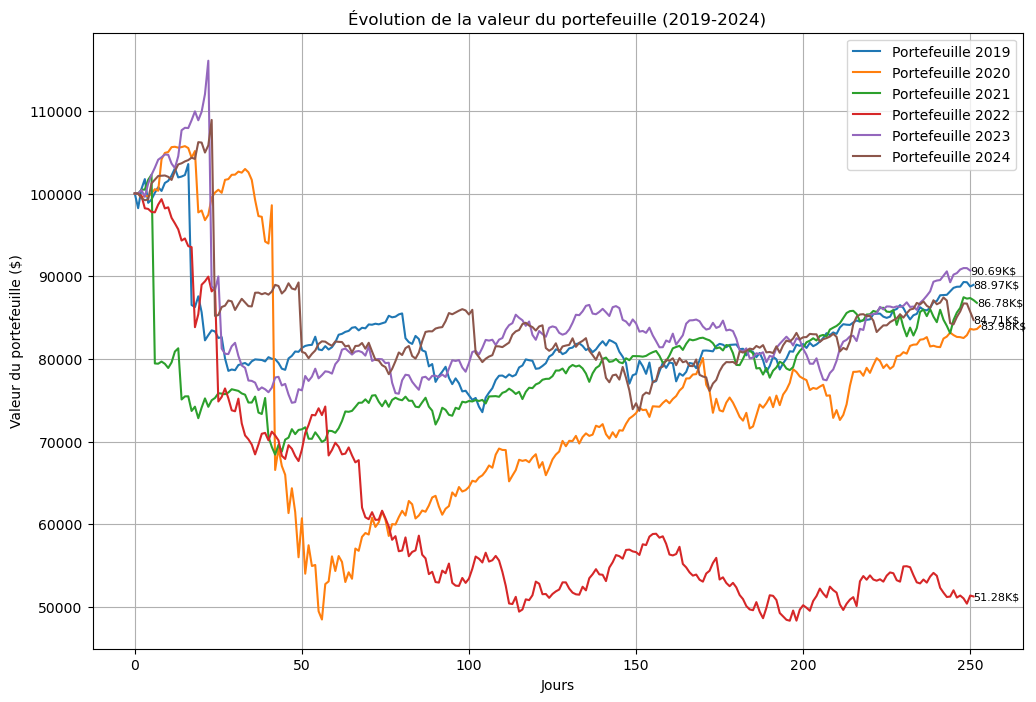

In [57]:
# Visualisation des résultats avec data labels formatés en milliers
plt.figure(figsize=(12, 8))

for year, values in portfolio_values.items():
    plt.plot(values, label=f'Portefeuille {year}')
    
    # Ajouter un data label pour la valeur finale formatée en milliers
    final_value = values[-1]  # Dernière valeur de l'année
    final_value_k = final_value / 1000  # Conversion en milliers
    plt.text(len(values) - 1, final_value, f'{final_value_k:.2f}K$', 
             ha='left', va='center', fontsize=8, color='black')

plt.title('Évolution de la valeur du portefeuille (2019-2024)')
plt.xlabel('Jours')
plt.ylabel('Valeur du portefeuille ($)')
plt.legend()
plt.grid(True)
plt.show()